# FB2NEP Workbook 8 – Missing Data and Sensitivity Analysis

Version 0.0.1

In all real epidemiological datasets, some information is missing. In this workbook we focus more systematically on:

- What “missing data” mean in practice.
- Patterns of missingness in the FB2NEP cohort.
- Complete-case versus imputation-based analyses.
- Simple sensitivity analyses to assess robustness.
- A brief introduction to Bayesian thinking about missing data.

We work with a simple regression example using the synthetic FB2NEP cohort.

Run the first two code cells to set up the repository and load the data.

In [1]:
# FB2NEP bootstrap cell – use in *all* workbooks
#
# This cell initialises the repository context and loads the synthetic cohort
# into a DataFrame called df. It tries a few possible locations for scripts/bootstrap.py.

import pathlib
import runpy

bootstrap_candidates = [
    "scripts/bootstrap.py",
    "../scripts/bootstrap.py",
    "../../scripts/bootstrap.py",
]

bootstrap_ns = None

for rel in bootstrap_candidates:
    p = pathlib.Path(rel)
    if p.exists():
        print(f"Loading bootstrap from: {p}")
        bootstrap_ns = runpy.run_path(str(p))
        break
else:
    raise FileNotFoundError(
        "Could not find scripts/bootstrap.py. "
        "Please check that you are running this notebook inside fb2nep-epi."
    )

if "init" not in bootstrap_ns:
    raise RuntimeError("bootstrap.py does not define init().")

df, CTX = bootstrap_ns["init"]()

REPO_ROOT = CTX.repo_root
CSV_REL = CTX.csv_rel
IN_COLAB = CTX.in_colab

print("Repository root:", REPO_ROOT)
print("Main dataset:", CSV_REL)
print("df shape:", df.shape)
print("IN_COLAB:", IN_COLAB)

Loading bootstrap from: ../scripts/bootstrap.py
Dataset found: data/synthetic/fb2nep.csv ✅
Repository root: /Users/gunter/Documents/fb2nep-epi
Main dataset: data/synthetic/fb2nep.csv
df shape: (25000, 27)
IN_COLAB: False


In [2]:
# Imports used throughout this workbook
#
# - numpy, pandas: general data handling
# - matplotlib: simple visualisations
# - statsmodels: regression and multiple imputation (MICE)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.imputation.mice import MICEData, MICE



%matplotlib inline

In [3]:
# Quick inspection of the main dataset
# This is just to remind ourselves of the structure of the FB2NEP cohort.

df.head()

,id,baseline_date,follow_up_years,age,sex,menopausal_status,IMD_quintile,SES_class,smoking_status,physical_activity,...,ssb_ml_d,fibre_g_d,alcohol_units_wk,salt_g_d,plasma_vitC_umol_L,urinary_sodium_mmol_L,CVD_incident,CVD_date,Cancer_incident,Cancer_date
0,1,2011-05-27,6.44,59,M,NaN,5,ABC1,current,low,...,25.0,21.9,0.0,5.9,40.3,114.0,1,2017-10-15,1,2016-03-10
1,2,2010-08-14,7.50,60,M,NaN,4,ABC1,never,low,...,76.0,26.2,0.0,5.8,36.1,112.7,0,NaN,0,NaN
2,3,2012-04-28,7.57,54,F,post,4,ABC1,former,moderate,...,169.0,8.1,0.0,7.1,46.3,128.8,0,NaN,0,NaN
3,4,2015-01-20,5.71,67,F,post,3,ABC1,never,low,...,104.0,17.9,8.0,7.0,31.4,100.9,0,NaN,0,NaN
4,5,2013-04-10,6.30,70,M,NaN,1,C2DE,current,moderate,...,304.0,24.2,0.0,10.5,33.1,168.8,0,NaN,0,NaN


## Background: what do we mean by “missing data”?

Before inspecting missingness in the FB2NEP dataset, we first clarify what *missing* means in an epidemiological context.

### (a) What can be missing?

Information can be missing at several levels:

- **Whole participants**  
  These individuals never appear in the analysis dataset (not recruited, withdrew immediately, or provided no usable data).

- **Entire visits or time points**  
  A participant attends baseline but not follow-up; in longitudinal data this appears as absent rows or missing whole sets of variables.

- **Individual variables (items)**  
  A single measurement is absent:  
  - SBP not taken or not recorded.  
  - Height or weight missing.  
  - A questionnaire item skipped.

In this workbook we mainly deal with **item-level missingness** in outcome, exposure, and covariates within a regression model.

### (b) Different types of missing entries

Not all missing values have the same meaning:

- **Item non-response**  
  A measurement *should* exist, but is not observed.

- **Unit non-response**  
  A whole clinic visit or questionnaire is missing.

- **Structurally missing (“not applicable”)**  
  These entries are *supposed* to be missing. Examples:  
  - `menopausal_status` in men.  
  - `CVD_date` for participants without a CVD event.  

Structural missingness is not imputed because it is determined by the logic of the variable.

### (c) What does “missing” mean in the dataset?

In the FB2NEP dataset, missing values appear as `NaN` in pandas.

This means:

- The participant **exists** in the cohort.  
- But the dataset contains **no recorded value** for that variable.

It does **not** mean:

- zero,  
- “no disease”,  
- “never”,  
- or any other substantive category.

Example:

- `SBP = 0` mmHg would be physiologically impossible and signals an error.  
- `SBP = NaN` means the measurement was not collected or not available.

Missingness therefore concerns the **measurement**, not the person. A missing BMI does not mean the participant lacks body mass; it means the dataset lacks the recorded value.

In the rest of this workbook, we focus on:

- How much item-level missingness there is in our chosen variables.  
- How different ways of handling these missing values (complete-case analysis, single imputation, multiple imputation) can influence our regression results.

## 1. Missingness overview

We now turn to the concrete pattern of missing data in the FB2NEP cohort.

In this workbook we focus on a simple blood pressure model:

- Outcome: `SBP` (systolic blood pressure).
- Main exposure: `BMI` (body mass index).
- Covariates: `age`, `sex`, `smoking_status`, `SES_class`.

We begin by calculating the proportion of missing values in each of these variables.

In [4]:
# Select variables of interest for this workbook.
#
# We keep the code robust by checking that each variable actually exists in df.

vars_of_interest = [v for v in ["SBP", "BMI", "age", "sex", "smoking_status", "SES_class"] if v in df.columns]
df_an = df[vars_of_interest].copy()

# Ensure that categorical variables are coded as categories.
if "sex" in df_an.columns:
    df_an["sex"] = df_an["sex"].astype("category")
if "smoking_status" in df_an.columns:
    df_an["smoking_status"] = df_an["smoking_status"].astype("category")
if "SES_class" in df_an.columns:
    df_an["SES_class"] = df_an["SES_class"].astype("category")

# Proportion of missing values for each variable.
missing_props = df_an.isna().mean()
missing_props

SBP               0.05404
BMI               0.00020
age               0.00000
sex               0.00000
smoking_status    0.00000
SES_class         0.00000
dtype: float64

The table above shows the **fraction** of missing values for each variable.

- A value of `0.05` means that 5% of observations for that variable are missing.
- The amount of missing data can differ markedly between variables.

To visualise this pattern we can draw a simple bar chart.

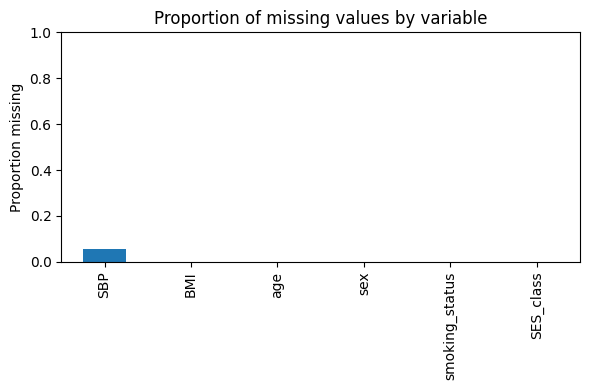

In [5]:
# Bar plot of missingness for the selected variables.

plt.figure(figsize=(6, 4))
missing_props.sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Proportion missing")
plt.ylim(0, 1)
plt.title("Proportion of missing values by variable")
plt.tight_layout()
plt.show()

### 1.1 Conceptual mechanisms of missingness

The statistical properties of any missing-data method depend on **how** data are missing. Three standard mechanisms are:

- **MCAR – Missing Completely At Random**  
  The probability that a value is missing does not depend on any observed or unobserved variable. For example, a blood sample is lost due to a laboratory freezer failure that affects samples randomly.

- **MAR – Missing At Random**  
  The probability that a value is missing may depend on **observed** variables, but not on the value of the missing variable itself, after conditioning on the observed data. For example, BMI may be more likely to be missing among older participants, but conditional on age and sex, missingness is unrelated to the true BMI value.

- **MNAR – Missing Not At Random**  
  The probability that a value is missing still depends on the *unobserved* value, even after conditioning on observed covariates. For example, participants with very high BMI may be particularly reluctant to be weighed, even after adjusting for age, sex and smoking.

In practice we rarely know the true mechanism. A key message is: therefore:

> We can rarely “fix” missing data, but we can **make our assumptions explicit** and **explore sensitivity** of results to these assumptions.

## 2. Complete-case versus single imputation

We now fit a simple linear regression model with systolic blood pressure (SBP) as the outcome and BMI as the main exposure, adjusted for age and available covariates.

We compare two strategies:

1. **Complete-case analysis**: use only participants with no missing values in any of the model variables. This is easy but can lead to loss of power and biased estimates, unless data are MCAR (or satisfy a slightly weaker condition).
2. **Single imputation**: fill in missing values with a single “best guess” (mean or mode) and analyse the resulting dataset as if it were complete. This preserves sample size but underestimates uncertainty.

We start with the complete-case analysis.

In [6]:
# 2.1 Complete-case analysis
# --------------------------
# We drop any row that has at least one missing value in the variables
# we intend to use in the model.

df_cc = df_an.dropna()
print(f"Number of complete cases: {len(df_cc)} out of {len(df_an)} participants")

# Construct the regression formula step by step.
formula = "SBP ~ BMI + age"
if "sex" in df_cc.columns:
    formula += " + C(sex)"
if "smoking_status" in df_cc.columns:
    formula += " + C(smoking_status)"
if "SES_class" in df_cc.columns:
    formula += " + C(SES_class)"

print("Model formula:", formula)

# Fit the ordinary least squares (OLS) model using statsmodels.
model_cc = smf.ols(formula, data=df_cc).fit()

# Create a compact summary table with estimates and 95% confidence intervals.
cc_summary = model_cc.summary2().tables[1][["Coef.", "Std.Err.", "[0.025", "0.975]"]]
cc_summary

Number of complete cases: 23644 out of 25000 participants
Model formula: SBP ~ BMI + age + C(sex) + C(smoking_status) + C(SES_class)


,Coef.,Std.Err.,[0.025,0.975]
Intercept,116.235821,0.623362,115.013992,117.457650
C(sex)[T.M],0.826422,0.146646,0.538987,1.113857
C(smoking_status)[T.former],-3.769110,0.213703,-4.187982,-3.350238
C(smoking_status)[T.never],-3.999863,0.222713,-4.436394,-3.563332
C(SES_class)[T.C2DE],0.625642,0.146691,0.338118,0.913167
BMI,0.520793,0.016346,0.488753,0.552833
age,0.629589,0.007674,0.614548,0.644630


In [7]:
# 2.2 Single imputation (mean/mode)
# ---------------------------------
# For illustration, we perform a very simple single imputation:
# - For numeric variables, replace missing values with the mean.
# - For categorical variables, replace missing values with the most frequent category.
#
# This method is *not* recommended for serious analyses, but it is useful to
# demonstrate how different handling of missing data can influence estimates.

df_si = df_an.copy()

for col in df_si.columns:
    if df_si[col].dtype.kind in "biufc":  # numeric types
        df_si[col] = df_si[col].fillna(df_si[col].mean())
    else:  # categorical or object types
        df_si[col] = df_si[col].fillna(df_si[col].mode().iloc[0])

# Fit the same model to the single-imputed dataset.
model_si = smf.ols(formula, data=df_si).fit()

si_summary = model_si.summary2().tables[1][["Coef.", "Std.Err.", "[0.025", "0.975]"]]

# Compare coefficients from complete-case and single-imputed analyses.
comparison_2 = pd.DataFrame({
    "cc_coef": cc_summary["Coef."],
    "si_coef": si_summary["Coef."],
    "cc_SE": cc_summary["Std.Err."],
    "si_SE": si_summary["Std.Err."]
})
comparison_2

,cc_coef,si_coef,cc_SE,si_SE
Intercept,116.235821,118.837049,0.623362,0.596412
C(sex)[T.M],0.826422,0.780563,0.146646,0.140255
C(smoking_status)[T.former],-3.769110,-3.553618,0.213703,0.204224
C(smoking_status)[T.never],-3.999863,-3.751960,0.222713,0.212855
C(SES_class)[T.C2DE],0.625642,0.590145,0.146691,0.140279
BMI,0.520793,0.494893,0.016346,0.015634
age,0.629589,0.594035,0.007674,0.007326


In the table above, focus on the **BMI** coefficient and its standard error in the two approaches.

- Do the point estimates differ?  
- Are the confidence intervals similar or noticeably different?  
- How many observations were used in the complete-case analysis compared with the imputed analysis?

Single imputation keeps the original sample size but fails to reflect the extra uncertainty caused by missing data, so standard errors are often too small.

## 3. Multiple imputation with MICE (simplified)

Multiple imputation aims to improve on single imputation by:

1. Drawing **several** plausible values for each missing observation, generating multiple imputed datasets.
2. Fitting the analysis model in each dataset.
3. Combining estimates and standard errors using **Rubin's rules**.

Conceptually, this is closer to the idea of uncertainty used elsewhere in statistics: we acknowledge that the missing values could have been different, and we propagate this uncertainty into the final estimates.

Here we use a simple implementation of **MICE (Multivariate Imputation by Chained Equations)** from `statsmodels`. The details of the imputation models are beyond the scope of FB2NEP; we treat this as a black box and focus on the *idea* and the comparison of results.

In [8]:
# 3.1 Prepare data for MICE
# -------------------------
# MICE in statsmodels expects a numeric design matrix. We therefore use
# one-hot encoding (dummy variables) for categories.

df_mice = pd.get_dummies(df_an, drop_first=True)

# Create a MICEData object that stores the data and handles the chained equations.
mice_data = MICEData(df_mice)

# Outcome and predictors: here we use all available predictors for imputation
# and analysis (this is not always ideal, but sufficient for illustration).
endog = "SBP"
predictors = [c for c in df_mice.columns if c != endog]
formula_mice = endog + " ~ " + " + ".join(predictors)
print("MICE model formula:")
print(formula_mice)

# 3.2 Fit the MICE model with m=5 imputations.
# --------------------------------------------
# The MICE object performs imputations internally and then fits the regression
# model repeatedly, combining estimates automatically.

# Note: first argument = formula, second = *class* with .from_formula (sm.OLS)
mice = MICE(formula_mice, sm.OLS, mice_data)
result_mice = mice.fit(5)

# The summary is long, but it shows pooled estimates and standard errors.
result_mice.summary()


MICE model formula:
SBP ~ BMI + age + sex_M + smoking_status_former + smoking_status_never + SES_class_C2DE


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: MICE
========================================================================================
Method:                           MICE              Sample size:                  25000 
Model:                            OLS               Scale                         126.91
Dependent variable:               SBP               Num. imputations              10    
----------------------------------------------------------------------------------------
                               Coef.   Std.Err.    t     P>|t|   [0.025   0.975]   FMI  
----------------------------------------------------------------------------------------
Intercept                     116.1727   0.6182 187.9141 0.0000 114.9610 117.3844 0.0374
sex_M[T.True]                   0.8236   0.1476   5.5793 0.0000   0.5342   1.1129 0.0661
smoking_status_former[T.True]  -3.7768   0.2154 -17.5353 0.0000  -4.1990  -3.3547 0.0700
smoking_status_never[T.True]   -3.9711   0.2216 -17.9192 0.0000  -4.4055  -3.5368 0.0458
SES_class_C2DE[T.True]          0.6196   0.1475   4.2019 0.0000   0.3306   0.9086 0.0640
BMI                             0.5187   0.0163  31.8059 0.0000   0.4867   0.5506 0.0494
age                             0.6317   0.0078  81.2642 0.0000   0.6164   0.6469 0.0811
========================================================================================

"""

In [9]:
# 3.3 Extract and compare key coefficients across methods
# -------------------------------------------------------
# We focus on the BMI effect. For the MICE model, BMI is numeric and should
# appear among the exogenous (predictor) names.

# 1. Get BMI coefficient and SE from the complete-case and single-impute models
bmi_cc_coef = model_cc.params.get("BMI", np.nan)
bmi_cc_se   = model_cc.bse.get("BMI", np.nan)

bmi_si_coef = model_si.params.get("BMI", np.nan)
bmi_si_se   = model_si.bse.get("BMI", np.nan)

print("Raw BMI coefficients from the two frequentist models:")
print(f"  Complete-case BMI coef: {bmi_cc_coef:.6f}")
print(f"  Single-impute BMI coef: {bmi_si_coef:.6f}")

# 2. Wrap the pooled MICE parameters and standard errors in a DataFrame
pooled = pd.DataFrame(
    {
        "coef": result_mice.params,
        "se": result_mice.bse,
    },
    index=result_mice.model.exog_names,
)

if "BMI" in pooled.index:
    bmi_mi_coef = pooled.loc["BMI", "coef"]
    bmi_mi_se   = pooled.loc["BMI", "se"]
else:
    bmi_mi_coef = np.nan
    bmi_mi_se   = np.nan

print(f"  Multiple-impute BMI coef: {bmi_mi_coef:.6f}")

# 3. Assemble comparison table
summary_methods = pd.DataFrame({
    "method":   ["complete_case", "single_impute", "multiple_impute"],
    "BMI_coef": [bmi_cc_coef,     bmi_si_coef,     bmi_mi_coef],
    "BMI_SE":   [bmi_cc_se,       bmi_si_se,       bmi_mi_se],
    "n_used":   [len(df_cc),      len(df_si),      len(df_an)],
})

summary_methods


Raw BMI coefficients from the two frequentist models:
  Complete-case BMI coef: 0.520793
  Single-impute BMI coef: 0.494893
  Multiple-impute BMI coef: 0.518659


,method,BMI_coef,BMI_SE,n_used
0,complete_case,0.520793,0.016346,23644
1,single_impute,0.494893,0.015634,25000
2,multiple_impute,0.518659,0.016307,25000


This table summarises the estimated BMI effect and its standard error under three strategies.

- Multiple imputation typically has **smaller standard errors** than complete-case analysis (because it uses more data) but **larger standard errors** than naive single imputation (because it acknowledges imputation uncertainty).
- In well-behaved situations, point estimates are often similar across methods, but they **can** differ, especially if missingness is related to key variables.

Even a moderately sceptical hippo would insist that the assumptions behind each method are made clear in any report or dissertation.

## 4. Simple sensitivity analyses

No missing-data method is perfect, and the mechanism of missingness is usually not known with certainty. **Sensitivity analyses** explore how robust our conclusions are to alternative assumptions or modelling choices.

Here we illustrate two simple strategies:

1. Restricting the analysis to a more “ordinary” BMI range.
2. Applying a small **delta adjustment** to imputed values to mimic an MNAR scenario.

### 4.1 Restricting the BMI range

Extreme values can sometimes drive results and may also be more prone to measurement error or missingness. As a basic sensitivity analysis, we refit the complete-case model **excluding** participants with BMI ≥ 40 kg/m² and compare results.

In [10]:
# 4.1 Restrict analysis to BMI < 40 kg/m^2

if "BMI" in df_cc.columns:
    df_cc_restricted = df_cc[df_cc["BMI"] < 40]
    print(f"Complete cases in original model:   {len(df_cc)}")
    print(f"Complete cases with BMI < 40:      {len(df_cc_restricted)}")

    model_cc_rest = smf.ols(formula, data=df_cc_restricted).fit()

    cc_rest_summary = model_cc_rest.summary2().tables[1][["Coef.", "Std.Err.", "[0.025", "0.975]"]]

    comp_rest = pd.DataFrame({
        "original_coef": cc_summary["Coef."],
        "restricted_coef": cc_rest_summary["Coef."],
        "original_SE": cc_summary["Std.Err."],
        "restricted_SE": cc_rest_summary["Std.Err."],
    })
    comp_rest

Complete cases in original model:   23644
Complete cases with BMI < 40:      23585


### 4.3 Sensitivity to adjustment set (model specification)

Sensitivity analyses are not limited to missing data. In epidemiology, it is good practice
to ask how sensitive our main association is to *modelling choices*, in particular:

- Which covariates we adjust for (potential confounders).
- How we code exposures and covariates (continuous vs categories).
- Functional form (for example, linear vs quadratic).

Here we consider the association between BMI and SBP and compare two regression models:

1. A **minimally adjusted model**:  
   $$
   \text{SBP} = \beta_0 + \beta_1 \cdot \text{BMI} + \beta_2 \cdot \text{age} + \beta_3 \cdot \text{sex} + \varepsilon.
   $$

2. A **more fully adjusted model** that also includes potential confounders:  
   $$
   \text{SBP} = \beta_0 + \beta_1 \cdot \text{BMI} + \beta_2 \cdot \text{age}
   + \beta_3 \cdot \text{sex} + \beta_4 \cdot \text{smoking status}
   + \beta_5 \cdot \text{SES} + \beta_6 \cdot \text{physical activity} + \varepsilon.
   $$

The aim is to see whether the estimated BMI effect (\\(\\beta_1\\)) is stable or changes
substantially when we change the adjustment set. Large changes might indicate strong
confounding or model misspecification.


In [12]:
# 4.3 Sensitivity to adjustment set (model specification)
# ------------------------------------------------------
# We use the complete-case dataset df_cc and compare:
# - A minimally adjusted model: SBP ~ BMI + age + sex
# - A more fully adjusted model: add smoking_status, SES_class, physical_activity (if present)

# Ensure we are working with complete cases for all relevant variables.
covars_min = ["age", "sex"]
covars_full = ["age", "sex", "smoking_status", "SES_class", "physical_activity"]

# Keep only variables that actually exist in the data.
covars_min = [v for v in covars_min if v in df_cc.columns]
covars_full = [v for v in covars_full if v in df_cc.columns]

vars_min = ["SBP", "BMI"] + covars_min
vars_full = ["SBP", "BMI"] + covars_full

df_cc_min = df_cc[vars_min].dropna()
df_cc_full = df_cc[vars_full].dropna()

print(f"Minimally adjusted model:   {len(df_cc_min)} complete cases")
print(f"Fully adjusted model:       {len(df_cc_full)} complete cases")

# Construct formulas
formula_min = "SBP ~ BMI"
for cov in covars_min:
    if str(df_cc_min[cov].dtype) == "category":
        formula_min += f" + C({cov})"
    else:
        formula_min += f" + {cov}"

formula_full = "SBP ~ BMI"
for cov in covars_full:
    if str(df_cc_full[cov].dtype) == "category":
        formula_full += f" + C({cov})"
    else:
        formula_full += f" + {cov}"

print("Minimal model formula:   ", formula_min)
print("Full model formula:      ", formula_full)

# Fit both models
model_min = smf.ols(formula_min, data=df_cc_min).fit()
model_full = smf.ols(formula_full, data=df_cc_full).fit()

# Extract BMI coefficients and standard errors
bmi_min_coef = model_min.params.get("BMI", np.nan)
bmi_min_se   = model_min.bse.get("BMI", np.nan)

bmi_full_coef = model_full.params.get("BMI", np.nan)
bmi_full_se   = model_full.bse.get("BMI", np.nan)

sens_adjust = pd.DataFrame({
    "model": ["minimal", "full"],
    "BMI_coef": [bmi_min_coef, bmi_full_coef],
    "BMI_SE": [bmi_min_se, bmi_full_se],
    "n_used": [len(df_cc_min), len(df_cc_full)],
})

sens_adjust


Minimally adjusted model:   23644 complete cases
Fully adjusted model:       23644 complete cases
Minimal model formula:    SBP ~ BMI + age + C(sex)
Full model formula:       SBP ~ BMI + age + C(sex) + C(smoking_status) + C(SES_class)


,model,BMI_coef,BMI_SE,n_used
0,minimal,0.543354,0.016432,23644
1,full,0.520793,0.016346,23644


## 5. Bayesian approaches

Bayesian methods treat missing values as **unknown parameters** and estimate them jointly with all other parameters in the model.

In a Bayesian missing-data model:

- We specify a **likelihood** for the observed data given parameters and missing values.
- We specify **prior distributions** for both the model parameters and the missing values.
- We use Markov Chain Monte Carlo (MCMC) or related algorithms to sample from the joint **posterior distribution**.

The resulting posterior samples naturally incorporate uncertainty about missing values into uncertainty about regression coefficients. This is conceptually similar to multiple imputation, but the Bayesian approach integrates all uncertainty in a single framework and can make it easier to specify complex MNAR models.

Implementing Bayesian missing-data models is beyond the scope of FB2NEP, but it is useful to be aware of them, particularly for more advanced research projects.

In [ ]:
# Bayesian regression using PyMC
# ------------------------------
# Model: SBP ~ BMI + age + sex
# We use weakly informative priors and sample using NUTS (Hamiltonian MCMC).

import pymc as pm
import arviz as az
import numpy as np

# Subset for Bayesian modelling: complete cases (simplest teaching example)
df_bayes = df_an.dropna(subset=["SBP", "BMI", "age", "sex"]).copy()

# Convert sex to 0/1 coding for the Bayesian model
df_bayes["sex_M"] = (df_bayes["sex"] == "M").astype(int)

y = df_bayes["SBP"].values
BMI = df_bayes["BMI"].values
age = df_bayes["age"].values
sex_M = df_bayes["sex_M"].values

with pm.Model() as model_bayes:
    
    # Priors
    intercept = pm.Normal("intercept", mu=120, sigma=20)
    beta_BMI = pm.Normal("beta_BMI", mu=0, sigma=1)
    beta_age = pm.Normal("beta_age", mu=0, sigma=1)
    beta_sex = pm.Normal("beta_sex", mu=0, sigma=1)
    
    # Noise (half-normal ensures positivity)
    sigma = pm.HalfNormal("sigma", sigma=10)
    
    # Linear predictor
    mu = (
        intercept
        + beta_BMI * BMI
        + beta_age * age
        + beta_sex * sex_M
    )
    
    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1500, target_accept=0.9, random_seed=11088)

# Summarise key results
az.summary(trace, var_names=["intercept", "beta_BMI", "beta_age", "beta_sex", "sigma"])


In [ ]:
with model_bayes:
    ppc = pm.sample_posterior_predictive(trace, random_seed=11088)

az.plot_ppc(ppc)
plt.show()


In [ ]:
print("Frequentist OLS BMI estimate:", model_cc.params["BMI"])
print("Multiple imputation BMI estimate:", bmi_mi_coef)

az.summary(trace, var_names=["beta_BMI"])[["mean", "hdi_3%", "hdi_97%"]]


## 6. Practical mini-assignment

In this final section you will carry out a small, assignment-style analysis using the FB2NEP cohort.

### Task

1. Choose an **outcome** (for example, `SBP` or a biomarker).
2. Choose a main **exposure** (for example, `BMI`, `salt_g_d`, or `physical_activity`).
3. Choose at least **two covariates** (for example, `age`, `sex`, `SES_class`).
4. Inspect and describe the pattern of missingness in your chosen variables.
5. Fit three models:
   - Complete-case analysis.
   - Single imputation (mean/mode or another reasonable rule).
   - Multiple imputation using MICE.
6. Perform **one sensitivity analysis**, for example:
   - Restrict the analysis to a more typical range of the exposure.
   - Apply a small delta-based MNAR adjustment similar to Section 4.2.
7. Write a short interpretation (approximately 150–200 words) answering:
   - How do the point estimates differ between methods?  
   - How do the standard errors differ?  
   - How sensitive are your conclusions to the chosen assumptions?

The template below gives a starting point. You will need to replace placeholder variable names with your chosen variables and possibly adjust the code.

In [ ]:
# 6.1 Student template for a small missing-data analysis
# -----------------------------------------------------

# 1. Define variables for your analysis.
#    Replace the placeholder names below with real column names from df.

outcome = "SBP"            # e.g. "SBP"
exposure = "BMI"           # e.g. "BMI" or another continuous exposure
covariates = ["age", "sex"]  # add further covariates if desired

vars_stu = [outcome, exposure] + covariates
vars_stu = [v for v in vars_stu if v in df.columns]

df_stu = df[vars_stu].copy()

# Convert obvious categorical variables.
for cat_var in ["sex", "smoking_status", "SES_class"]:
    if cat_var in df_stu.columns:
        df_stu[cat_var] = df_stu[cat_var].astype("category")

# 2. Inspect missingness.
print("Proportion missing in each variable:")
print(df_stu.isna().mean())

# 3. Complete-case model.
df_stu_cc = df_stu.dropna()
print(f"Complete cases: {len(df_stu_cc)} out of {len(df_stu)}")

formula_stu = outcome + " ~ " + exposure
for cov in covariates:
    if cov in df_stu_cc.columns:
        if str(df_stu_cc[cov].dtype) == "category":
            formula_stu += f" + C({cov})"
        else:
            formula_stu += f" + {cov}"

print("Student model formula:", formula_stu)

model_stu_cc = smf.ols(formula_stu, data=df_stu_cc).fit()
stu_cc_summary = model_stu_cc.summary2().tables[1][["Coef.", "Std.Err.", "[0.025", "0.975]"]]

# 4. Single imputation (mean for numeric, mode for categorical).
df_stu_si = df_stu.copy()
for col in df_stu_si.columns:
    if df_stu_si[col].dtype.kind in "biufc":
        df_stu_si[col] = df_stu_si[col].fillna(df_stu_si[col].mean())
    else:
        df_stu_si[col] = df_stu_si[col].fillna(df_stu_si[col].mode().iloc[0])

model_stu_si = smf.ols(formula_stu, data=df_stu_si).fit()
stu_si_summary = model_stu_si.summary2().tables[1][["Coef.", "Std.Err.", "[0.025", "0.975]"]]

# 5. Multiple imputation via MICE (simplified).
df_stu_mice = pd.get_dummies(df_stu, drop_first=True)
mice_stu = MICEData(df_stu_mice)
endog_stu = outcome
pred_stu = [c for c in df_stu_mice.columns if c != endog_stu]
formula_stu_mice = endog_stu + " ~ " + " + ".join(pred_stu)

mice_mod_stu = MICE(formula_stu_mice, sm.OLS, mice_stu)
result_stu_mice = mice_mod_stu.fit(5)

# For simplicity, extract the exposure coefficient if present.
if exposure in result_stu_mice.params.index:
    exp_mi_coef = result_stu_mice.params[exposure]
    exp_mi_se = result_stu_mice.bse[exposure]
else:
    exp_mi_coef = np.nan
    exp_mi_se = np.nan

# 6. Simple comparison table for the main exposure.
exp_cc = stu_cc_summary.loc[exposure, "Coef."] if exposure in stu_cc_summary.index else np.nan
exp_cc_se = stu_cc_summary.loc[exposure, "Std.Err."] if exposure in stu_cc_summary.index else np.nan
exp_si = stu_si_summary.loc[exposure, "Coef."] if exposure in stu_si_summary.index else np.nan
exp_si_se = stu_si_summary.loc[exposure, "Std.Err."] if exposure in stu_si_summary.index else np.nan

stu_methods = pd.DataFrame({
    "method": ["complete_case", "single_impute", "multiple_impute"],
    "exposure_coef": [exp_cc, exp_si, exp_mi_coef],
    "exposure_SE": [exp_cc_se, exp_si_se, exp_mi_se],
    "n_used": [len(df_stu_cc), len(df_stu_si), len(df_stu)],
})

stu_methods